# HW11 - Descriptive Notebook

Note: Updated, to remove flattening in trainer function.

In this homework notebook, we will create a Wasserstein GAN with Convolution and Transpose Convolution layers, to be used on the MNIST dataset.

Get familiar with the code and write a small report (2 pages max), with answers to the questions listed at the end of the notebook.

**The report must be submitted in PDF format, before April 18th, 11.59pm!**

Do not forget to write your name and student ID on the report.

You may also submit your own copy of the notebook along with the report. If you do so, please add your name and ID to the cell below.

In [1]:
# Name: Xie Han Keong
# Student ID: 100 3876

### Imports needed

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms

from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
from matplotlib import figure
import numpy as np
import os

import utils

### Global variables

In [3]:
# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset
IMG_CHANNELS = 1
IMG_SIZE = 28

# Architecture
LATENT_SIZE = 64

In [4]:
print(DEVICE)

cuda


### Dataset

In [5]:
# Image transform to be applied to dataset:
# 1. Tensor conversion
# 2. Normalizing to tanh range [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

In [6]:
# MNIST train dataset
mnist = torchvision.datasets.MNIST(root='./', train=True, download=True, transform=transform)

### Critic model as a set of Conv2d layers

**Task1:** Rewrite the Critic model below, so that it uses Conv2d layers instead of fully connected ones shown in class.

You may look for inspiration in the encoder models used in Notebook 3 (W11S1 lecture).

The critic should use three Conv2d layers with progressive downsampling.

We do not advise to add more layers to the mix (BatchNorm, Dropout, etc.).

In [7]:
# Critic
class Critic(nn.Module):
    def __init__(self, in_channels, num_features):
        """
        Parameters:
        in_channels (int) - Number of input channels for the first convolutional layer
        num_features (int) - Number of features for the first convolutional layer (x2 for each layer after)
        """
        super(Critic, self).__init__()
        
        # Output score for real or fake image
        out_channels = 1
        
        self.f = nn.Sequential(                                  # In: 28 x 28
            nn.Conv2d(in_channels, num_features, 3, 2, 1),       # 14 x 14
            nn.LeakyReLU(0.2),
            self.Conv(num_features, num_features*2, 3, 2, 1),    # 7 x 7
            self.Conv(num_features*2, num_features*4, 3, 2, 0),  # 3 x 3
            nn.Conv2d(num_features*4, out_channels, 3, 1, 0),    # 1 x 1
        )                                                        # Out: 1 x 1
    
    def Conv(self, in_channels, out_channels, kernel_size, 
             stride=1, padding=0, dilation=1):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size,
                      stride, padding, dilation),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, x):
        return self.f(x).flatten(1)

#### Check Conv2d architecture for Critic model

In [8]:
print('Conv2d architecture for Critic:')
utils.check_Conv2d_architecture(28, [
    (3, 2, 1),
    (3, 2, 1),
    (3, 2, 0),
    (3, 1, 0)
])

Conv2d architecture for Critic:
# In: 28 x 28
Fractional output size: 14.5
nn.Conv2d(..., 3, 2, 1), # 14 x 14
Fractional output size: 7.5
nn.Conv2d(..., 3, 2, 1), # 7 x 7
nn.Conv2d(..., 3, 2, 0), # 3 x 3
nn.Conv2d(..., 3, 1, 0), # 1 x 1
# Out: 1 x 1


### Generator model as a set of Transposed Conv2d layers

**Task2:** Rewrite the Generator model below, so that it uses Transposed Conv2d layers instead of fully connected ones shown in class.

You may look for inspiration in the encoder models used in Notebooks 2 and 3 (W11S1 lecture).

The critic should use three Transposed Conv2d layers with progressive upsampling.

We do not advise to add more layers to the mix (BatchNorm, Dropout, etc.).

In [9]:
# Generator
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels, num_features):
        """
        Parameters:
        in_channels (int) - Number of input channels for the first transposed convolutional layer
        out_channels (int) - Number of output channels for the last transposed convolutional layer
        num_features (int) - Number of features for the last transposed convolutional layer
        """
        super(Generator, self).__init__()
        
        self.G = nn.Sequential(                                              # In: 1 x 1
            self.ConvTranspose(in_channels, num_features*8, 3, 1, 0, 0),     # 3 x 3
            self.ConvTranspose(num_features*8, num_features*4, 3, 2, 0, 0),  # 7 x 7
            self.ConvTranspose(num_features*4, num_features*2, 3, 2, 1, 1),  # 14 x 14
            nn.ConvTranspose2d(num_features*2, out_channels, 3, 2, 1, 1),    # 28 x 28
            nn.Tanh(),
        )                                                                    # Out: 28 x 28
    
    def ConvTranspose(self, in_channels, out_channels, kernel_size, 
                      stride=1, padding=0, output_padding=0, dilation=1):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride,
                               padding, output_padding, dilation),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.G(x)

#### Check ConvTranspose2d architecture for Generator model

In [10]:
print('ConvTranspose2d architecture for Generator:')
utils.check_ConvTranspose2d_architecture(1, [
    (3, 1, 0, 0),
    (3, 2, 0, 0),
    (3, 2, 1, 1),
    (3, 2, 1, 1),
])

ConvTranspose2d architecture for Generator:
# In: 1 x 1
nn.ConvTranspose2d(..., 3, 1, 0, 0), # 3 x 3
nn.ConvTranspose2d(..., 3, 2, 0, 0), # 7 x 7
nn.ConvTranspose2d(..., 3, 2, 1, 1), # 14 x 14
nn.ConvTranspose2d(..., 3, 2, 1, 1), # 28 x 28
# Out: 28 x 28


### Train function

In [11]:
def train(data_loader, critic, gen, optim_critic, optim_gen, num_epochs, num_steps, lambda_gp, save_path=None):
    """Train the Wasserstein GAN.
    
    Parameters:
    data_loader: Data loader to use for training
    critic: Critic model to train
    gen: Generator model to train
    optim_critic: Optimizer for the critic model
    optim_gen: Optimizer for the generator model
    num_epochs (int): Number of training epochs
    num_steps (tuple(int, int)): Number of training steps for critic model versus generator model
    lambda_gp (int | float): Gradient penalty constant
    save_path (str): Path to save training images
    """
    # Print seed for reproducibility
    print(f'seed: {torch.seed()}')
    
    # History trackers for training losses
    losses_critic = np.zeros(num_epochs)
    losses_gen = np.zeros(num_epochs)
    
    # Progress bars
    num_batches = len(data_loader)
    num_critic, num_gen = num_steps
    pbar_epoch = tqdm(desc='epoch', position=0, leave=True, total=num_epochs)
    pbar_critic = tqdm(desc='critic', position=1, leave=True, total=num_batches)
    pbar_gen = tqdm(desc='gen', position=2, leave=True, total=(num_batches//num_critic)*num_gen)
    
    # Fixed noise for testing after every epoch
    fixed_noise = torch.randn(100, LATENT_SIZE, 1, 1).to(DEVICE)
    
    for epoch in range(num_epochs):
        # Reset progress
        pbar_critic.reset()
        pbar_gen.reset()
        steps_critic = 0
        steps_gen = 0
        
        # Training loop
        for images, _ in data_loader:
            batch_size = images.shape[0]
            
            ###### Critic training ######
            
            # Prepare real and fake images
            images_real = images.to(DEVICE)
            noise = torch.randn(batch_size, LATENT_SIZE, 1, 1).to(DEVICE)
            images_fake = gen(noise)
            
            # Compute critic scores
            outputs_real = critic(images_real)
            outputs_fake = critic(images_fake)

            # Compute gradient penalty
            grad_penalty = utils.gradient_penalty(critic, images_real, images_fake, device=DEVICE)

            # Loss for critic
            loss_critic = outputs_fake.mean() - outputs_real.mean() + lambda_gp*grad_penalty
            
            # Backprop and optimize critic
            critic.zero_grad()
            loss_critic.backward()
            optim_critic.step()
            
            # Optional weight clipping on critic (Mentioned in WGAN paper)
            # for p in critic.parameters():
            #     p.data.clamp_(-0.01, 0.01)
            
            # Update critic progress
            losses_critic[epoch] = losses_critic[epoch]*(steps_critic/(steps_critic+1.)) + loss_critic.item()*(1./(steps_critic+1.))
            pbar_critic.set_description(f'critic (loss: {loss_critic.item():.5f})')
            pbar_critic.update()
            steps_critic += 1
            
            ###### Generator training ######
            
            # We train the generator num_gen times every time the critic trains
            # num_critic steps (when steps_critic is a multiple of num_critic)
            if steps_critic % num_critic == 0:
                for _ in range(num_gen):
                    # Create fake images
                    noise = torch.randn(batch_size, LATENT_SIZE, 1, 1).to(DEVICE)
                    images_fake = gen(noise)

                    # Compute critic scores for fake images
                    outputs_fake = critic(images_fake)

                    # Loss for generator
                    loss_gen = -outputs_fake.mean()

                    # Backprop and optimize generator
                    gen.zero_grad()
                    loss_gen.backward()
                    optim_gen.step()

                    # Update generator progress
                    losses_gen[epoch] = losses_gen[epoch]*(steps_gen/(steps_gen+1.)) + loss_gen.item()*(1./(steps_gen+1.))
                    pbar_gen.set_description(f'gen (loss: {loss_gen.item():.5f})')
                    pbar_gen.update()
                    steps_gen += 1
            
            # Display results
            if (steps_critic in (num_critic, num_batches)) or (steps_critic % 50 == 0):
                print('Epoch [{}/{}], Batch [{}/{}], loss_critic: {:.5f}, loss_gen: {:.5f}' 
                      .format(epoch+1, num_epochs, steps_critic, num_batches, loss_critic.item(), loss_gen.item()))
        
        # Refresh progress bars
        pbar_critic.refresh()
        pbar_gen.refresh()
        pbar_epoch.update()
        
        # Visualize samples
        if save_path is not None:
            plot_samples(gen, nrows=5, ncols=20, noise=fixed_noise,
                         save_path=os.path.join(save_path, f'epoch{epoch+1}.png'))
    
    # Display losses for both the generator and discriminator
    plt.figure()
    X = list(range(1, len(losses_critic)+1))
    plt.title('Training Loss')
    plt.plot(X, losses_critic, label='Critic')
    plt.plot(X, losses_gen, label='Generator')    
    plt.legend()
    plt.show()

### Visualization function

In [12]:
def plot_samples(gen, nrows=5, ncols=20, noise=None, figsize=None, save_path=None):
    # Calculate number of samples
    n_samples = nrows * ncols
    
    # Check figsize
    if figsize is None:
        figsize = (ncols, nrows)
    
    # Check noise
    if noise is None:
        noise = torch.randn(n_samples, LATENT_SIZE, 1, 1).to(DEVICE)
    
    # Generate fake images
    images_fake = gen(noise).cpu().detach().numpy()
    
    # Reshape and normalize to [0, 1]
    images_fake = images_fake.reshape(nrows, ncols, 28, 28) * 0.5 + 0.5
    
    # Create axes
    if save_path:
        # Use matplotlib.figure to avoid memory issues
        fig = figure.Figure(figsize=figsize)
        axes = [fig.add_subplot(nrows, ncols, i+1) for i in range(n_samples)]
    else:
        fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = np.array(axes).reshape(nrows, ncols)
    
    # Draw images
    for i in range(nrows):
        for j in range(ncols):
            axes[i][j].imshow(images_fake[i][j])
            axes[i][j].tick_params(which='both', left=False, labelleft=False, bottom=False, labelbottom=False)
    
    # Save or display image
    if save_path:
        # If path contains a directory, make directory if not exists
        head, tail = os.path.split(save_path)
        if head:
            os.makedirs(head, exist_ok=True)
        fig.savefig(save_path)
    else:
        plt.show()

### Experiment function

In [13]:
def run_experiment(experiment_name, batch_size, num_features,
                   num_epochs, num_steps, lambda_gp, optim_kwargs):
    ###### Setup ######
    
    # Create data loader
    data_loader = torch.utils.data.DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True)
    
    # Create critic model
    critic = Critic(in_channels=IMG_CHANNELS, num_features=num_features)
    critic.to(DEVICE)    
    
    # Create generator model
    gen = Generator(in_channels=LATENT_SIZE, out_channels=IMG_CHANNELS, num_features=num_features)
    gen.to(DEVICE)
    
    # Create optimizers for critic and generator
    optim_critic = torch.optim.Adam(critic.parameters(), **optim_kwargs)
    optim_gen = torch.optim.Adam(gen.parameters(), **optim_kwargs)
    
    ###### Training ######
    
    # Save path
    save_path = os.path.join('experiments', experiment_name)
    
    # Train critic and generator
    train(data_loader, critic, gen, optim_critic, optim_gen,
          num_epochs, num_steps, lambda_gp, save_path)
    
    return critic, gen

### Experiments

**Task 3:** Decide on a number of iterations num_epochs for training!

#### Experiment 5

seed: 101792809067000


epoch:   0%|          | 0/20 [00:00<?, ?it/s]

critic:   0%|          | 0/469 [00:00<?, ?it/s]

gen:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch [1/20], Batch [5/469], loss_critic: -2.87024, loss_gen: 0.74699
Epoch [1/20], Batch [50/469], loss_critic: -14.88373, loss_gen: 7.97628
Epoch [1/20], Batch [100/469], loss_critic: -11.80496, loss_gen: 6.74593
Epoch [1/20], Batch [150/469], loss_critic: -7.57310, loss_gen: 5.42695
Epoch [1/20], Batch [200/469], loss_critic: -6.54935, loss_gen: 5.07537
Epoch [1/20], Batch [250/469], loss_critic: -5.46634, loss_gen: 6.46113
Epoch [1/20], Batch [300/469], loss_critic: -5.61611, loss_gen: 5.62418
Epoch [1/20], Batch [350/469], loss_critic: -5.24461, loss_gen: 5.04907
Epoch [1/20], Batch [400/469], loss_critic: -5.15171, loss_gen: 4.48226
Epoch [1/20], Batch [450/469], loss_critic: -5.22823, loss_gen: 6.58959
Epoch [1/20], Batch [469/469], loss_critic: -5.41905, loss_gen: 7.16419
Epoch [2/20], Batch [5/469], loss_critic: -5.64410, loss_gen: 6.06458
Epoch [2/20], Batch [50/469], loss_critic: -5.38656, loss_gen: 6.65388
Epoch [2/20], Batch [100/469], loss_critic: -5.37754, loss_gen: 7.25

Epoch [11/20], Batch [250/469], loss_critic: -1.80910, loss_gen: 1.84041
Epoch [11/20], Batch [300/469], loss_critic: -2.51138, loss_gen: 1.33926
Epoch [11/20], Batch [350/469], loss_critic: -1.82883, loss_gen: 1.02076
Epoch [11/20], Batch [400/469], loss_critic: -2.10967, loss_gen: 2.12232
Epoch [11/20], Batch [450/469], loss_critic: -2.33216, loss_gen: 1.21418
Epoch [11/20], Batch [469/469], loss_critic: -1.56067, loss_gen: 0.59828
Epoch [12/20], Batch [5/469], loss_critic: -2.48275, loss_gen: 1.46907
Epoch [12/20], Batch [50/469], loss_critic: -2.04199, loss_gen: 1.54948
Epoch [12/20], Batch [100/469], loss_critic: -2.11273, loss_gen: 0.54100
Epoch [12/20], Batch [150/469], loss_critic: -1.81847, loss_gen: 0.55626
Epoch [12/20], Batch [200/469], loss_critic: -2.03594, loss_gen: 1.60394
Epoch [12/20], Batch [250/469], loss_critic: -2.03716, loss_gen: 0.36400
Epoch [12/20], Batch [300/469], loss_critic: -2.16800, loss_gen: 1.15045
Epoch [12/20], Batch [350/469], loss_critic: -2.14793,

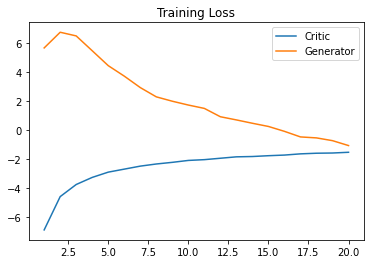

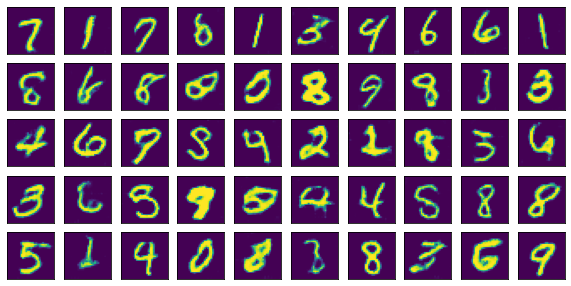

In [14]:
###### Experiment 5 ######

### Hyperparameters ###

# Data loader
batch_size = 128

# Architecture
num_features = 32

# Training
num_epochs = 20
num_steps = (5, 1)  # Critic to generator training ratio
lambda_gp = 10      # Gradient penalty constant

# Optimizer
optim_kwargs = dict(
    lr = 4e-4,
    betas = (0.5, 0.999),
)

### Running the experiment ###

# Experiment name
experiment_name = 'experiment5'

# Run experiment
critic, gen = run_experiment(experiment_name, batch_size, num_features,
                             num_epochs, num_steps, lambda_gp, optim_kwargs)

# Visualize samples
plot_samples(gen, nrows=5, ncols=10)

#### Experiment 4

seed: 96037322111000


epoch:   0%|          | 0/20 [00:00<?, ?it/s]

critic:   0%|          | 0/469 [00:00<?, ?it/s]

gen:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch [1/20], Batch [5/469], loss_critic: -4.30553, loss_gen: 3.85008
Epoch [1/20], Batch [50/469], loss_critic: -35.88769, loss_gen: 19.41886
Epoch [1/20], Batch [100/469], loss_critic: -46.92267, loss_gen: 27.12553
Epoch [1/20], Batch [150/469], loss_critic: -49.43875, loss_gen: 31.92884
Epoch [1/20], Batch [200/469], loss_critic: -50.12464, loss_gen: 36.51498
Epoch [1/20], Batch [250/469], loss_critic: -49.30110, loss_gen: 39.28796
Epoch [1/20], Batch [300/469], loss_critic: -49.05411, loss_gen: 40.27269
Epoch [1/20], Batch [350/469], loss_critic: -49.26148, loss_gen: 40.60107
Epoch [1/20], Batch [400/469], loss_critic: -48.61464, loss_gen: 38.82044
Epoch [1/20], Batch [450/469], loss_critic: -48.14231, loss_gen: 39.21415
Epoch [1/20], Batch [469/469], loss_critic: -47.15862, loss_gen: 40.54127
Epoch [2/20], Batch [5/469], loss_critic: -48.10667, loss_gen: 39.48037
Epoch [2/20], Batch [50/469], loss_critic: -47.48647, loss_gen: 38.33373
Epoch [2/20], Batch [100/469], loss_critic: -4

Epoch [11/20], Batch [100/469], loss_critic: -9.21473, loss_gen: 24.99825
Epoch [11/20], Batch [150/469], loss_critic: -8.61486, loss_gen: 25.50166
Epoch [11/20], Batch [200/469], loss_critic: -8.91137, loss_gen: 25.14218
Epoch [11/20], Batch [250/469], loss_critic: -9.13048, loss_gen: 24.01413
Epoch [11/20], Batch [300/469], loss_critic: -8.73046, loss_gen: 23.79354
Epoch [11/20], Batch [350/469], loss_critic: -8.58315, loss_gen: 24.94501
Epoch [11/20], Batch [400/469], loss_critic: -8.88107, loss_gen: 24.47861
Epoch [11/20], Batch [450/469], loss_critic: -8.61754, loss_gen: 25.15253
Epoch [11/20], Batch [469/469], loss_critic: -7.28469, loss_gen: 24.71969
Epoch [12/20], Batch [5/469], loss_critic: -8.66630, loss_gen: 24.07466
Epoch [12/20], Batch [50/469], loss_critic: -7.77801, loss_gen: 24.16039
Epoch [12/20], Batch [100/469], loss_critic: -7.63118, loss_gen: 24.02424
Epoch [12/20], Batch [150/469], loss_critic: -8.10539, loss_gen: 23.84228
Epoch [12/20], Batch [200/469], loss_crit

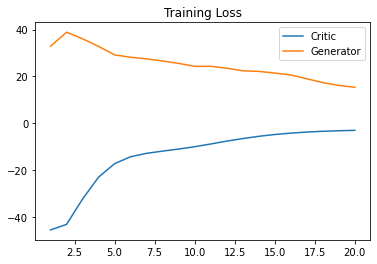

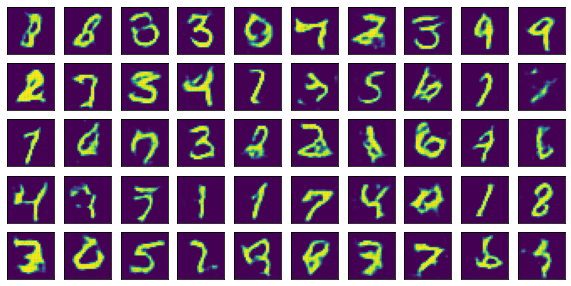

In [14]:
###### Experiment 4 ######

### Hyperparameters ###

# # Data loader
# batch_size = 128

# # Architecture
# num_features = 64

# # Training
# num_epochs = 20
# num_steps = (5, 1)  # Critic to generator training ratio
# lambda_gp = 10      # Gradient penalty constant

# # Optimizer
# optim_kwargs = dict(
#     lr = 2e-4,
#     betas = (0.5, 0.9),
# )

#### Experiment 3

seed: 70356888444600


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

steps_f:   0%|          | 0/469 [00:00<?, ?it/s]

steps_G:   0%|          | 0/2345 [00:00<?, ?it/s]

Epoch [1/10], Batch [1/469], loss_f: 32.65231, loss_G: -1.03432
Epoch [1/10], Batch [50/469], loss_f: 3.34934, loss_G: 0.73470
Epoch [1/10], Batch [100/469], loss_f: -0.42262, loss_G: 0.00717
Epoch [1/10], Batch [150/469], loss_f: -1.08903, loss_G: 0.37608
Epoch [1/10], Batch [200/469], loss_f: -0.47843, loss_G: -0.15174
Epoch [1/10], Batch [250/469], loss_f: -0.73715, loss_G: 0.13955
Epoch [1/10], Batch [300/469], loss_f: 0.01677, loss_G: -0.39319
Epoch [1/10], Batch [350/469], loss_f: 0.00251, loss_G: -0.29922
Epoch [1/10], Batch [400/469], loss_f: 0.09510, loss_G: -0.27394
Epoch [1/10], Batch [450/469], loss_f: 0.03255, loss_G: -0.26141
Epoch [1/10], Batch [469/469], loss_f: -0.01469, loss_G: -0.21245
Epoch [2/10], Batch [1/469], loss_f: -0.00597, loss_G: -0.23278
Epoch [2/10], Batch [50/469], loss_f: 0.09622, loss_G: -0.40177
Epoch [2/10], Batch [100/469], loss_f: 0.02011, loss_G: -0.24970
Epoch [2/10], Batch [150/469], loss_f: 0.04540, loss_G: -0.12043
Epoch [2/10], Batch [200/469

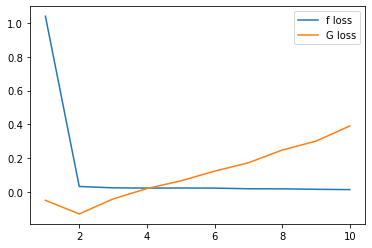

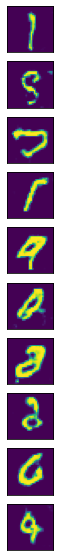

In [14]:
###### Experiment 3 ######

# ### Hyperparameters ###

# # Data loader
# batch_size = 128

# # Architecture
# num_features = 64

# # Training
# num_epochs = 10
# num_steps = (1, 5)  # Critic to generator training ratio
# lambda_gp = 1       # Gradient penalty constant

# # Optimizer
# optim_kwargs = dict(
#     lr = 2e-4,
#     momentum = 0.5,
# )

#### Experiment 2

seed: 39840254182600


epoch:   0%|          | 0/100 [00:00<?, ?it/s]

steps_f:   0%|          | 0/469 [00:00<?, ?it/s]

steps_G:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch [1/100], Batch [3/469], loss_f: 23.86836, loss_G: -0.27143
Epoch [1/100], Batch [50/469], loss_f: 2.75827, loss_G: 0.07231
Epoch [1/100], Batch [100/469], loss_f: 0.18489, loss_G: 0.01906
Epoch [1/100], Batch [150/469], loss_f: -0.06775, loss_G: -0.06028
Epoch [1/100], Batch [200/469], loss_f: -0.05509, loss_G: -0.11416
Epoch [1/100], Batch [250/469], loss_f: -0.05347, loss_G: -0.16329
Epoch [1/100], Batch [300/469], loss_f: -0.04205, loss_G: -0.14953
Epoch [1/100], Batch [350/469], loss_f: -0.02487, loss_G: -0.15590
Epoch [1/100], Batch [400/469], loss_f: -0.04213, loss_G: -0.16567
Epoch [1/100], Batch [450/469], loss_f: -0.03473, loss_G: -0.18755
Epoch [1/100], Batch [469/469], loss_f: -0.02932, loss_G: -0.13721
Epoch [2/100], Batch [3/469], loss_f: -0.05801, loss_G: -0.17034
Epoch [2/100], Batch [50/469], loss_f: -0.04112, loss_G: -0.17719
Epoch [2/100], Batch [100/469], loss_f: -0.01963, loss_G: -0.13450
Epoch [2/100], Batch [150/469], loss_f: -0.05084, loss_G: -0.17779
Epoch

Epoch [12/100], Batch [200/469], loss_f: -0.02483, loss_G: 0.28511
Epoch [12/100], Batch [250/469], loss_f: -0.02024, loss_G: 0.22196
Epoch [12/100], Batch [300/469], loss_f: -0.02351, loss_G: 0.38748
Epoch [12/100], Batch [350/469], loss_f: -0.01548, loss_G: 0.26290
Epoch [12/100], Batch [400/469], loss_f: -0.01928, loss_G: 0.32700
Epoch [12/100], Batch [450/469], loss_f: -0.01383, loss_G: 0.27833
Epoch [12/100], Batch [469/469], loss_f: -0.01390, loss_G: 0.27347
Epoch [13/100], Batch [3/469], loss_f: -0.04449, loss_G: 0.29237
Epoch [13/100], Batch [50/469], loss_f: -0.01076, loss_G: 0.40420
Epoch [13/100], Batch [100/469], loss_f: -0.03217, loss_G: 0.39627
Epoch [13/100], Batch [150/469], loss_f: -0.04583, loss_G: 0.43851
Epoch [13/100], Batch [200/469], loss_f: -0.02010, loss_G: 0.29967
Epoch [13/100], Batch [250/469], loss_f: -0.02620, loss_G: 0.28062
Epoch [13/100], Batch [300/469], loss_f: -0.01771, loss_G: 0.39728
Epoch [13/100], Batch [350/469], loss_f: -0.01254, loss_G: 0.2232

Epoch [23/100], Batch [300/469], loss_f: -0.02982, loss_G: 0.64457
Epoch [23/100], Batch [350/469], loss_f: -0.01602, loss_G: 0.65439
Epoch [23/100], Batch [400/469], loss_f: -0.01844, loss_G: 0.65828
Epoch [23/100], Batch [450/469], loss_f: -0.03604, loss_G: 0.67003
Epoch [23/100], Batch [469/469], loss_f: -0.02582, loss_G: 0.62841
Epoch [24/100], Batch [3/469], loss_f: -0.01881, loss_G: 0.63257
Epoch [24/100], Batch [50/469], loss_f: -0.01342, loss_G: 0.57091
Epoch [24/100], Batch [100/469], loss_f: -0.00876, loss_G: 0.59913
Epoch [24/100], Batch [150/469], loss_f: -0.04059, loss_G: 0.67209
Epoch [24/100], Batch [200/469], loss_f: -0.01405, loss_G: 0.62123
Epoch [24/100], Batch [250/469], loss_f: -0.00698, loss_G: 0.71225
Epoch [24/100], Batch [300/469], loss_f: -0.03226, loss_G: 0.69791
Epoch [24/100], Batch [350/469], loss_f: -0.03121, loss_G: 0.66290
Epoch [24/100], Batch [400/469], loss_f: -0.02536, loss_G: 0.69866
Epoch [24/100], Batch [450/469], loss_f: -0.03869, loss_G: 0.7315

Epoch [34/100], Batch [400/469], loss_f: -0.02458, loss_G: 1.00768
Epoch [34/100], Batch [450/469], loss_f: -0.01815, loss_G: 0.96921
Epoch [34/100], Batch [469/469], loss_f: -0.00949, loss_G: 1.08332
Epoch [35/100], Batch [3/469], loss_f: -0.02185, loss_G: 1.06431
Epoch [35/100], Batch [50/469], loss_f: -0.01991, loss_G: 1.08850
Epoch [35/100], Batch [100/469], loss_f: -0.03019, loss_G: 1.03651
Epoch [35/100], Batch [150/469], loss_f: -0.02098, loss_G: 1.04094
Epoch [35/100], Batch [200/469], loss_f: -0.01600, loss_G: 0.99574
Epoch [35/100], Batch [250/469], loss_f: -0.02251, loss_G: 1.06741
Epoch [35/100], Batch [300/469], loss_f: -0.02445, loss_G: 1.06428
Epoch [35/100], Batch [350/469], loss_f: -0.00666, loss_G: 1.06221
Epoch [35/100], Batch [400/469], loss_f: -0.01776, loss_G: 1.10625
Epoch [35/100], Batch [450/469], loss_f: -0.02790, loss_G: 1.10129
Epoch [35/100], Batch [469/469], loss_f: -0.01559, loss_G: 1.04031
Epoch [36/100], Batch [3/469], loss_f: -0.04004, loss_G: 1.00946


Epoch [45/100], Batch [469/469], loss_f: -0.02343, loss_G: 1.38652
Epoch [46/100], Batch [3/469], loss_f: -0.02446, loss_G: 1.44668
Epoch [46/100], Batch [50/469], loss_f: -0.02922, loss_G: 1.38691
Epoch [46/100], Batch [100/469], loss_f: -0.03070, loss_G: 1.37120
Epoch [46/100], Batch [150/469], loss_f: -0.01359, loss_G: 1.37253
Epoch [46/100], Batch [200/469], loss_f: -0.03225, loss_G: 1.47827
Epoch [46/100], Batch [250/469], loss_f: -0.00751, loss_G: 1.33169
Epoch [46/100], Batch [300/469], loss_f: -0.02182, loss_G: 1.40878
Epoch [46/100], Batch [350/469], loss_f: -0.02543, loss_G: 1.35123
Epoch [46/100], Batch [400/469], loss_f: -0.01682, loss_G: 1.38484
Epoch [46/100], Batch [450/469], loss_f: -0.03218, loss_G: 1.38247
Epoch [46/100], Batch [469/469], loss_f: -0.00372, loss_G: 1.40386
Epoch [47/100], Batch [3/469], loss_f: -0.02620, loss_G: 1.40851
Epoch [47/100], Batch [50/469], loss_f: -0.02451, loss_G: 1.43033
Epoch [47/100], Batch [100/469], loss_f: -0.03185, loss_G: 1.38591
E

Epoch [57/100], Batch [50/469], loss_f: -0.02303, loss_G: 1.63034
Epoch [57/100], Batch [100/469], loss_f: -0.01749, loss_G: 1.67089
Epoch [57/100], Batch [150/469], loss_f: -0.02270, loss_G: 1.62123
Epoch [57/100], Batch [200/469], loss_f: -0.03049, loss_G: 1.61078
Epoch [57/100], Batch [250/469], loss_f: -0.01907, loss_G: 1.59596
Epoch [57/100], Batch [300/469], loss_f: -0.01075, loss_G: 1.59918
Epoch [57/100], Batch [350/469], loss_f: -0.01625, loss_G: 1.60800
Epoch [57/100], Batch [400/469], loss_f: -0.00652, loss_G: 1.64026
Epoch [57/100], Batch [450/469], loss_f: -0.02828, loss_G: 1.60259
Epoch [57/100], Batch [469/469], loss_f: -0.01572, loss_G: 1.67868
Epoch [58/100], Batch [3/469], loss_f: -0.01391, loss_G: 1.69499
Epoch [58/100], Batch [50/469], loss_f: -0.01388, loss_G: 1.62423
Epoch [58/100], Batch [100/469], loss_f: -0.02283, loss_G: 1.65251
Epoch [58/100], Batch [150/469], loss_f: -0.01608, loss_G: 1.66492
Epoch [58/100], Batch [200/469], loss_f: -0.02311, loss_G: 1.67985

Epoch [68/100], Batch [150/469], loss_f: -0.03442, loss_G: 1.82150
Epoch [68/100], Batch [200/469], loss_f: -0.01297, loss_G: 1.74653
Epoch [68/100], Batch [250/469], loss_f: -0.01338, loss_G: 1.75133
Epoch [68/100], Batch [300/469], loss_f: -0.03048, loss_G: 1.74793
Epoch [68/100], Batch [350/469], loss_f: -0.02147, loss_G: 1.77866
Epoch [68/100], Batch [400/469], loss_f: -0.03439, loss_G: 1.79777
Epoch [68/100], Batch [450/469], loss_f: -0.02832, loss_G: 1.80926
Epoch [68/100], Batch [469/469], loss_f: -0.01682, loss_G: 1.77017
Epoch [69/100], Batch [3/469], loss_f: -0.02931, loss_G: 1.75922
Epoch [69/100], Batch [50/469], loss_f: -0.02166, loss_G: 1.76583
Epoch [69/100], Batch [100/469], loss_f: -0.01023, loss_G: 1.77212
Epoch [69/100], Batch [150/469], loss_f: -0.02558, loss_G: 1.75882
Epoch [69/100], Batch [200/469], loss_f: -0.01627, loss_G: 1.84586
Epoch [69/100], Batch [250/469], loss_f: -0.02433, loss_G: 1.83431
Epoch [69/100], Batch [300/469], loss_f: -0.03256, loss_G: 1.7722

Epoch [79/100], Batch [250/469], loss_f: -0.01035, loss_G: 1.85994
Epoch [79/100], Batch [300/469], loss_f: -0.03147, loss_G: 1.88665
Epoch [79/100], Batch [350/469], loss_f: -0.01626, loss_G: 1.81003
Epoch [79/100], Batch [400/469], loss_f: -0.01665, loss_G: 1.88525
Epoch [79/100], Batch [450/469], loss_f: -0.01664, loss_G: 1.89013
Epoch [79/100], Batch [469/469], loss_f: -0.02756, loss_G: 1.85069
Epoch [80/100], Batch [3/469], loss_f: -0.01408, loss_G: 1.86070
Epoch [80/100], Batch [50/469], loss_f: -0.03090, loss_G: 1.80264
Epoch [80/100], Batch [100/469], loss_f: -0.01825, loss_G: 1.86461
Epoch [80/100], Batch [150/469], loss_f: -0.02408, loss_G: 1.91722
Epoch [80/100], Batch [200/469], loss_f: -0.01661, loss_G: 1.84368
Epoch [80/100], Batch [250/469], loss_f: -0.02946, loss_G: 1.92605
Epoch [80/100], Batch [300/469], loss_f: -0.01624, loss_G: 1.87912
Epoch [80/100], Batch [350/469], loss_f: -0.02489, loss_G: 1.85510
Epoch [80/100], Batch [400/469], loss_f: -0.02117, loss_G: 1.9036

Epoch [90/100], Batch [350/469], loss_f: -0.02428, loss_G: 1.97567
Epoch [90/100], Batch [400/469], loss_f: -0.02313, loss_G: 2.00758
Epoch [90/100], Batch [450/469], loss_f: -0.02127, loss_G: 2.09144
Epoch [90/100], Batch [469/469], loss_f: -0.03259, loss_G: 1.97193
Epoch [91/100], Batch [3/469], loss_f: -0.02551, loss_G: 1.96427
Epoch [91/100], Batch [50/469], loss_f: -0.01949, loss_G: 2.00057
Epoch [91/100], Batch [100/469], loss_f: -0.02560, loss_G: 2.02204
Epoch [91/100], Batch [150/469], loss_f: -0.01764, loss_G: 1.96371
Epoch [91/100], Batch [200/469], loss_f: -0.02326, loss_G: 2.06118
Epoch [91/100], Batch [250/469], loss_f: -0.02275, loss_G: 1.97098
Epoch [91/100], Batch [300/469], loss_f: -0.02538, loss_G: 1.95237
Epoch [91/100], Batch [350/469], loss_f: -0.02450, loss_G: 1.97303
Epoch [91/100], Batch [400/469], loss_f: -0.02835, loss_G: 2.02744
Epoch [91/100], Batch [450/469], loss_f: -0.02108, loss_G: 2.02453
Epoch [91/100], Batch [469/469], loss_f: -0.02505, loss_G: 2.0245

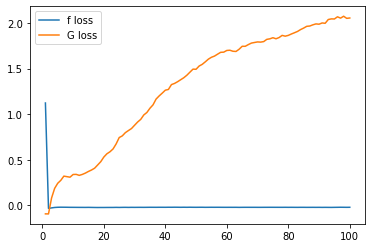

In [13]:
###### Experiment 2 ######

# ### Hyperparameters ###

# # Data loader
# batch_size = 128

# # Architecture
# num_features = 32

# # Training
# num_epochs = 100
# train_steps = (3, 4)   # Critic to generator training ratio
# lambda_gp = 1          # Gradient penalty constant

# # Optimizer
# optim_kwargs = dict(
#     lr = 2e-4,
#     momentum = 0.5,
# )

#### Experiment 1

seed: 19730019033400


epoch:   0%|          | 0/100 [00:00<?, ?it/s]

d_steps:   0%|          | 0/469 [00:00<?, ?it/s]

g_steps:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch [1/100], Batch [50/469], d_loss: -0.00015, g_loss: -0.00263
Epoch [1/100], Batch [100/469], d_loss: -0.00100, g_loss: -0.00234
Epoch [1/100], Batch [150/469], d_loss: -0.00106, g_loss: -0.00300
Epoch [1/100], Batch [200/469], d_loss: -0.00084, g_loss: -0.00313
Epoch [1/100], Batch [250/469], d_loss: -0.00073, g_loss: -0.00210
Epoch [1/100], Batch [300/469], d_loss: -0.00074, g_loss: -0.00226
Epoch [1/100], Batch [350/469], d_loss: -0.00028, g_loss: -0.00206
Epoch [1/100], Batch [400/469], d_loss: -0.00023, g_loss: -0.00231
Epoch [1/100], Batch [450/469], d_loss: -0.00036, g_loss: -0.00304
Epoch [2/100], Batch [50/469], d_loss: -0.00013, g_loss: -0.00295
Epoch [2/100], Batch [100/469], d_loss: -0.00031, g_loss: -0.00266
Epoch [2/100], Batch [150/469], d_loss: 0.00006, g_loss: -0.00233
Epoch [2/100], Batch [200/469], d_loss: -0.00034, g_loss: -0.00189
Epoch [2/100], Batch [250/469], d_loss: -0.00014, g_loss: -0.00243
Epoch [2/100], Batch [300/469], d_loss: -0.00042, g_loss: -0.0020

Epoch [14/100], Batch [350/469], d_loss: -0.00654, g_loss: 0.00173
Epoch [14/100], Batch [400/469], d_loss: 0.00087, g_loss: 0.03372
Epoch [14/100], Batch [450/469], d_loss: -0.00420, g_loss: -0.01906
Epoch [15/100], Batch [50/469], d_loss: -0.01272, g_loss: 0.00944
Epoch [15/100], Batch [100/469], d_loss: -0.01073, g_loss: -0.00221
Epoch [15/100], Batch [150/469], d_loss: -0.00376, g_loss: 0.00171
Epoch [15/100], Batch [200/469], d_loss: -0.00154, g_loss: -0.04456
Epoch [15/100], Batch [250/469], d_loss: -0.00283, g_loss: 0.02775
Epoch [15/100], Batch [300/469], d_loss: -0.00176, g_loss: -0.01402
Epoch [15/100], Batch [350/469], d_loss: 0.00040, g_loss: -0.01235
Epoch [15/100], Batch [400/469], d_loss: 0.00046, g_loss: -0.01094
Epoch [15/100], Batch [450/469], d_loss: 0.00049, g_loss: -0.00997
Epoch [16/100], Batch [50/469], d_loss: 0.00033, g_loss: -0.00811
Epoch [16/100], Batch [100/469], d_loss: -0.00019, g_loss: -0.00689
Epoch [16/100], Batch [150/469], d_loss: -0.00032, g_loss: -

Epoch [28/100], Batch [150/469], d_loss: -0.00501, g_loss: 0.00338
Epoch [28/100], Batch [200/469], d_loss: -0.00547, g_loss: 0.01662
Epoch [28/100], Batch [250/469], d_loss: -0.00701, g_loss: -0.01249
Epoch [28/100], Batch [300/469], d_loss: -0.00533, g_loss: -0.00281
Epoch [28/100], Batch [350/469], d_loss: -0.00797, g_loss: 0.00315
Epoch [28/100], Batch [400/469], d_loss: -0.00662, g_loss: 0.00083
Epoch [28/100], Batch [450/469], d_loss: -0.00630, g_loss: 0.00359
Epoch [29/100], Batch [50/469], d_loss: -0.01051, g_loss: 0.00575
Epoch [29/100], Batch [100/469], d_loss: -0.00522, g_loss: 0.00773
Epoch [29/100], Batch [150/469], d_loss: -0.00382, g_loss: 0.01786
Epoch [29/100], Batch [200/469], d_loss: -0.01760, g_loss: -0.00545
Epoch [29/100], Batch [250/469], d_loss: -0.00413, g_loss: -0.03190
Epoch [29/100], Batch [300/469], d_loss: -0.00332, g_loss: 0.01786
Epoch [29/100], Batch [350/469], d_loss: -0.00758, g_loss: 0.00716
Epoch [29/100], Batch [400/469], d_loss: -0.00580, g_loss: 

Epoch [41/100], Batch [400/469], d_loss: -0.00040, g_loss: 0.01833
Epoch [41/100], Batch [450/469], d_loss: 0.00032, g_loss: -0.01521
Epoch [42/100], Batch [50/469], d_loss: 0.00044, g_loss: 0.00496
Epoch [42/100], Batch [100/469], d_loss: -0.00086, g_loss: 0.03437
Epoch [42/100], Batch [150/469], d_loss: -0.00258, g_loss: -0.00545
Epoch [42/100], Batch [200/469], d_loss: -0.00023, g_loss: -0.02835
Epoch [42/100], Batch [250/469], d_loss: -0.00315, g_loss: 0.02072
Epoch [42/100], Batch [300/469], d_loss: -0.00226, g_loss: -0.00822
Epoch [42/100], Batch [350/469], d_loss: 0.00011, g_loss: 0.00133
Epoch [42/100], Batch [400/469], d_loss: -0.00309, g_loss: -0.00069
Epoch [42/100], Batch [450/469], d_loss: -0.00217, g_loss: 0.00939
Epoch [43/100], Batch [50/469], d_loss: -0.00433, g_loss: -0.00181
Epoch [43/100], Batch [100/469], d_loss: -0.00053, g_loss: 0.00853
Epoch [43/100], Batch [150/469], d_loss: -0.00022, g_loss: 0.00225
Epoch [43/100], Batch [200/469], d_loss: -0.00201, g_loss: -0

Epoch [55/100], Batch [200/469], d_loss: 0.00110, g_loss: 0.01868
Epoch [55/100], Batch [250/469], d_loss: -0.00084, g_loss: -0.00117
Epoch [55/100], Batch [300/469], d_loss: -0.00037, g_loss: 0.00702
Epoch [55/100], Batch [350/469], d_loss: -0.00317, g_loss: -0.01244
Epoch [55/100], Batch [400/469], d_loss: -0.00133, g_loss: -0.03332
Epoch [55/100], Batch [450/469], d_loss: -0.00213, g_loss: 0.01301
Epoch [56/100], Batch [50/469], d_loss: -0.00328, g_loss: 0.01961
Epoch [56/100], Batch [100/469], d_loss: -0.00175, g_loss: -0.01079
Epoch [56/100], Batch [150/469], d_loss: 0.00202, g_loss: 0.00252
Epoch [56/100], Batch [200/469], d_loss: -0.00281, g_loss: 0.00887
Epoch [56/100], Batch [250/469], d_loss: 0.00249, g_loss: 0.01743
Epoch [56/100], Batch [300/469], d_loss: 0.00265, g_loss: -0.03604
Epoch [56/100], Batch [350/469], d_loss: -0.00117, g_loss: 0.00973
Epoch [56/100], Batch [400/469], d_loss: -0.00302, g_loss: -0.03027
Epoch [56/100], Batch [450/469], d_loss: -0.00176, g_loss: 0.

Epoch [69/100], Batch [50/469], d_loss: -0.00133, g_loss: -0.01472
Epoch [69/100], Batch [100/469], d_loss: 0.00009, g_loss: 0.00649
Epoch [69/100], Batch [150/469], d_loss: -0.00001, g_loss: 0.01291
Epoch [69/100], Batch [200/469], d_loss: -0.00064, g_loss: -0.00196
Epoch [69/100], Batch [250/469], d_loss: -0.00030, g_loss: -0.00616
Epoch [69/100], Batch [300/469], d_loss: -0.00116, g_loss: -0.00062
Epoch [69/100], Batch [350/469], d_loss: -0.00306, g_loss: -0.00140
Epoch [69/100], Batch [400/469], d_loss: 0.00191, g_loss: 0.02732
Epoch [69/100], Batch [450/469], d_loss: 0.00000, g_loss: -0.03533
Epoch [70/100], Batch [50/469], d_loss: -0.00639, g_loss: -0.00247
Epoch [70/100], Batch [100/469], d_loss: 0.00073, g_loss: -0.00947
Epoch [70/100], Batch [150/469], d_loss: -0.00162, g_loss: -0.00075
Epoch [70/100], Batch [200/469], d_loss: -0.00535, g_loss: -0.00628
Epoch [70/100], Batch [250/469], d_loss: 0.00152, g_loss: -0.02770
Epoch [70/100], Batch [300/469], d_loss: -0.00219, g_loss:

Epoch [82/100], Batch [350/469], d_loss: -0.00098, g_loss: 0.00052
Epoch [82/100], Batch [400/469], d_loss: -0.00110, g_loss: -0.00307
Epoch [82/100], Batch [450/469], d_loss: 0.00086, g_loss: -0.00424
Epoch [83/100], Batch [50/469], d_loss: -0.00161, g_loss: -0.00892
Epoch [83/100], Batch [100/469], d_loss: -0.00102, g_loss: 0.00493
Epoch [83/100], Batch [150/469], d_loss: 0.00403, g_loss: -0.00386
Epoch [83/100], Batch [200/469], d_loss: 0.00043, g_loss: 0.01031
Epoch [83/100], Batch [250/469], d_loss: 0.00081, g_loss: -0.02332
Epoch [83/100], Batch [300/469], d_loss: -0.00152, g_loss: 0.02059
Epoch [83/100], Batch [350/469], d_loss: -0.00108, g_loss: 0.01962
Epoch [83/100], Batch [400/469], d_loss: -0.00144, g_loss: -0.01740
Epoch [83/100], Batch [450/469], d_loss: 0.00044, g_loss: 0.01001
Epoch [84/100], Batch [50/469], d_loss: -0.00014, g_loss: 0.00981
Epoch [84/100], Batch [100/469], d_loss: -0.00067, g_loss: 0.01632
Epoch [84/100], Batch [150/469], d_loss: -0.00118, g_loss: -0.0

Epoch [96/100], Batch [200/469], d_loss: -0.00007, g_loss: 0.02038
Epoch [96/100], Batch [250/469], d_loss: 0.00119, g_loss: -0.02310
Epoch [96/100], Batch [300/469], d_loss: -0.00050, g_loss: -0.01008
Epoch [96/100], Batch [350/469], d_loss: 0.00291, g_loss: 0.01289
Epoch [96/100], Batch [400/469], d_loss: -0.00110, g_loss: -0.02733
Epoch [96/100], Batch [450/469], d_loss: 0.00165, g_loss: 0.02390
Epoch [97/100], Batch [50/469], d_loss: -0.00002, g_loss: -0.03632
Epoch [97/100], Batch [100/469], d_loss: 0.00055, g_loss: 0.02029
Epoch [97/100], Batch [150/469], d_loss: 0.00087, g_loss: 0.00499
Epoch [97/100], Batch [200/469], d_loss: -0.00142, g_loss: -0.00872
Epoch [97/100], Batch [250/469], d_loss: -0.00012, g_loss: 0.02400
Epoch [97/100], Batch [300/469], d_loss: -0.00101, g_loss: 0.00783
Epoch [97/100], Batch [350/469], d_loss: 0.00001, g_loss: -0.03411
Epoch [97/100], Batch [400/469], d_loss: 0.00161, g_loss: 0.01306
Epoch [97/100], Batch [450/469], d_loss: 0.00004, g_loss: -0.008

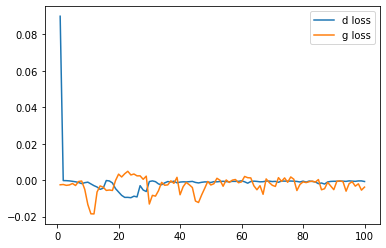

In [14]:
###### Experiment 1 ######

# The output in this cell has been saved from a previous experiment.
# The code used was similar, but has unfortunately been overwritten.
# The results are still kept here for future reference.

### Questions and expected answers for the report

1. Copy and paste the code for your Critic class. Briefly explain your choice of architecture.


2. Copy and paste the code for your Generator class. Briefly explain your choice of architecture.


3. For how many iterations did you have to train when using Wasserstein with Conv/TransposeConv layers to get plausible images from the generator? Is it training faster than the Fully Connected Wasserstein/Vanilla GAN?


4. Display some samples generated by your trained generator. Do they look plausible?


5. Let us assume we use Conv2d layers in the Critic. We do NOT use Transposed Conv2d layers, but only Fully Connected layers in the Generator. Would the GAN still be able to train both models or would it encounter difficulties? Discuss.